In [1]:
import os
import pprint as pp

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

# TEOTIL3 
# Tutorial 02: NVE's "regine" catchments

Although, in principle, TEOTIL3 can be used with any user-defined set of catchments, in practice it is almost always used with [NVE's "regine" catchment network](https://www.nve.no/kart/kartdata/vassdragsdata/nedborfelt-regine/), which provides the most detailed subdivision of Norwegian watersheds currently available. Within the regine dataset, each catchment (or sub-, inter- or coastal catchment) is assigned a unique ID based on its position in the catchment hierarchy (see [here](https://www.nve.no/media/2297/regines-inndelingssystem.pdf) for a detailed description).

As described in Tutorial 01, one of the core inputs to TEOTIL3 is an adjacency matrix describing hydrological connectivity between catchments. TEOTIL3 includes an algorithm to determine the hydrological order from the regine codes - see the notebook for `T2-2`, [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-2_catchment_hierarchy.ipynb), for details. **This algortihm is not perfect**, since the regine codes alone do not contain enough information to uniquely determine hydrological sorting. Nevertheless, the new algorithm includes a number of improvements compared to previous versions of the model (see [here](https://github.com/NIVANorge/teotil3/issues/11) for a comparison).

This tutorial illustrates some features of TEOTIL3 designed to make it easier to work with the regine catchments.

## 1. Get geospatial data for the regine catchments

Core datasets for TEOTIL3 - including the regine catchments - have been updated as part of Task 2.1 (see the development notebooks [here](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development)). The code below reads the latest catchment dataset, together with the latest administrative boundaries (both from 2022).

In [2]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


In [3]:
# Define datasets of interest
# Yaer for regine polygons
reg_year = 2022

# Year for admin. boundaries
admin_year = 2022

reg_gdf = teo.io.get_regine_geodataframe(eng, admin_year, regine_year=reg_year)
reg_gdf.head()

,regine,vassom,a_cat_poly_km2,ospar_region,komnr,fylnr,a_agri_km2,a_glacier_km2,a_lake_km2,a_other_km2,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_cat_land_km2,a_lake_nve_km2,runoff_mm/yr,q_cat_m3/s,geometry
0,001.10,001,1.442790,Skagerrak,3001,30,0.000000,0.0,0.000013,0.311648,0.281940,0.000000,0.000000,0.849188,0.849201,1.160850,0.000000,602,0.02214,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,001,1.432479,Skagerrak,3001,30,0.000000,0.0,0.048098,0.002223,0.000067,0.004615,0.000000,1.377476,1.430189,1.432412,0.043955,620,0.02814,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,001,0.340160,Skagerrak,3001,30,0.000000,0.0,0.036623,0.000000,0.000045,0.000000,0.000000,0.303492,0.340114,0.340114,0.000000,594,0.00640,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001,17.647822,Skagerrak,3001,30,1.895549,0.0,0.122567,0.000000,0.000000,0.467374,0.131585,15.030746,17.647822,17.647822,0.186340,637,0.35623,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,001,41.298255,Skagerrak,3001,30,1.573851,0.0,7.513687,0.000000,0.000000,2.250799,0.161524,29.798394,41.298255,41.298255,7.344123,637,0.83362,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


## 2. Determine hydrological connectivity

The function `teo.io.assign_regine_hierarchy` attempts to determine the hydrological order from the regine codes. See [this notebook](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-2_catchment_hierarchy.ipynb) for a description of how the algorithm works, and the issue [here](https://github.com/NIVANorge/teotil3/issues/11) for an overview of its limitations.

In [4]:
# Determine hydrological connectivity
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)
reg_gdf.head()

100.00 % of regines assigned.


,regine,regine_down,vassom,a_cat_poly_km2,ospar_region,komnr,fylnr,a_agri_km2,a_glacier_km2,a_lake_km2,...,a_sea_km2,a_upland_km2,a_urban_km2,a_wood_km2,ar50_tot_a_km2,a_cat_land_km2,a_lake_nve_km2,runoff_mm/yr,q_cat_m3/s,geometry
0,001.10,001.,001,1.442790,Skagerrak,3001,30,0.000000,0.0,0.000013,...,0.281940,0.000000,0.000000,0.849188,0.849201,1.160850,0.000000,602.0,0.02214,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,001.,001,1.432479,Skagerrak,3001,30,0.000000,0.0,0.048098,...,0.000067,0.004615,0.000000,1.377476,1.430189,1.432412,0.043955,620.0,0.02814,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,001.1A1,001,0.340160,Skagerrak,3001,30,0.000000,0.0,0.036623,...,0.000045,0.000000,0.000000,0.303492,0.340114,0.340114,0.000000,594.0,0.00640,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001.1A20,001,17.647822,Skagerrak,3001,30,1.895549,0.0,0.122567,...,0.000000,0.467374,0.131585,15.030746,17.647822,17.647822,0.186340,637.0,0.35623,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,001.1A2A,001,41.298255,Skagerrak,3001,30,1.573851,0.0,7.513687,...,0.000000,2.250799,0.161524,29.798394,41.298255,41.298255,7.344123,637.0,0.83362,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


## 3. Explore the regine dataset

The basic regine dataset shown above does not yet contain enough information to simulate nutrient fluxes, but it does include a lot of spatial information regarding the catchments themselves. As illustrated in Tutorial 01, TEOTIL3 includes some useful tools for visualising the catchment network. The first step is to use the adjacency matrix created from the regine codes to build a directed acyclic graph (DAG) of the catchment hierarchy.

In [5]:
# Build network graph from adjacency matrix
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

**This network is a representation of the entire Norwegian hydrological system** and includes data for more than 24000 (sub-)catchments. As a simple example, we will explore the network in the vicinity of regine `028.A3`.

Local attributes for catchment '028.A3':
{'a_agri_km2': 1.136491,
 'a_cat_land_km2': 1.598408,
 'a_cat_poly_km2': 1.598408,
 'a_glacier_km2': 0.0,
 'a_lake_km2': 0.047808,
 'a_lake_nve_km2': 0.0,
 'a_other_km2': 0.0,
 'a_sea_km2': 0.0,
 'a_upland_km2': 0.0,
 'a_urban_km2': 0.325552,
 'a_wood_km2': 0.088558,
 'ar50_tot_a_km2': 1.598408,
 'fylnr': '11',
 'geometry': <MULTIPOLYGON (((-42446.92 6555130.89, -42407.07 6555125.3, -42375.16 655513...>,
 'komnr': '1120',
 'ospar_region': 'North Sea',
 'q_cat_m3/s': 0.04827,
 'regine': '028.A3',
 'regine_down': '028.A2',
 'runoff_mm/yr': 953.0,
 'vassom': '028'}


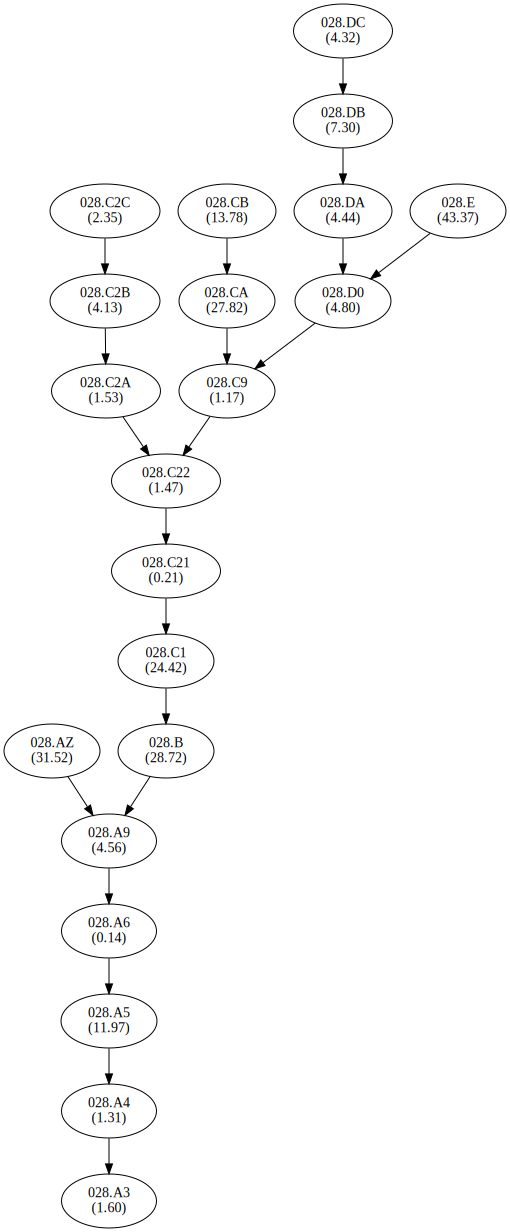

In [6]:
# Catchment of interest
reg_id = "028.A3"

# Get 'local' data for catchment
print(f"Local attributes for catchment '{reg_id}':")
pp.pprint(g.nodes[reg_id]["local"])

# Plot network upstream
teo.vis.plot_network(g, reg_id, direct="up", stat="local", quant="a_cat_land_km2")

Similarly, by using `direct="down"`, we can plot the network downstream to the coast (and into the OSPAR maritime regions - see section 3.2.4 [here](https://nivanorge.github.io/teotil2/pages/07_1000_lakes.html) for an overview of these).

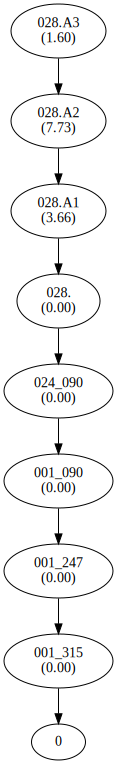

In [7]:
# Plot network downstream
teo.vis.plot_network(g, reg_id, direct="down", stat="local", quant="a_cat_land_km2")

Because we have spatial data representing the regine catchments (i.e. because `reg_gdf` is a *geo*dataframe, rather than a standard dataframe), we can also visualise the catchments spatially using `teo.vis.plot_catchment`. In particular, note the keyword arguments `include_connected` and `direct`:

 * If `include_connected=False`, the `direct` argument is ignored and only the specified regine is plotted
 
 * If `include_connected=True` and `direct="up"`, the specified regine will be merged with all upstream regines to create a complete catchment (rather than a sub- or inter-catchment). This will then be plotted
 
 * If `include_connected=True` and `direct="down"`, the specified regine will be merged with all regines on the downstream path and then plotted
 
These options are illustrated below.

<Axes: >

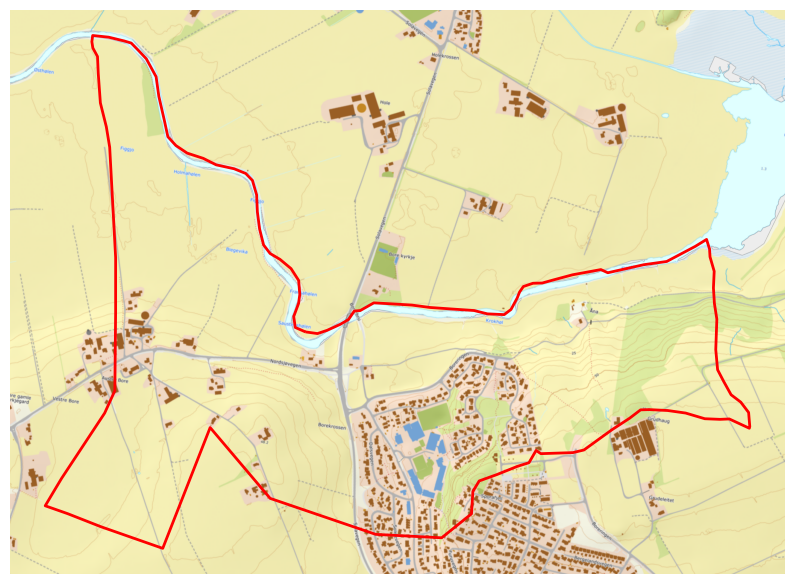

In [8]:
# Plot just the specified regine
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=False
)
ax

<Axes: >

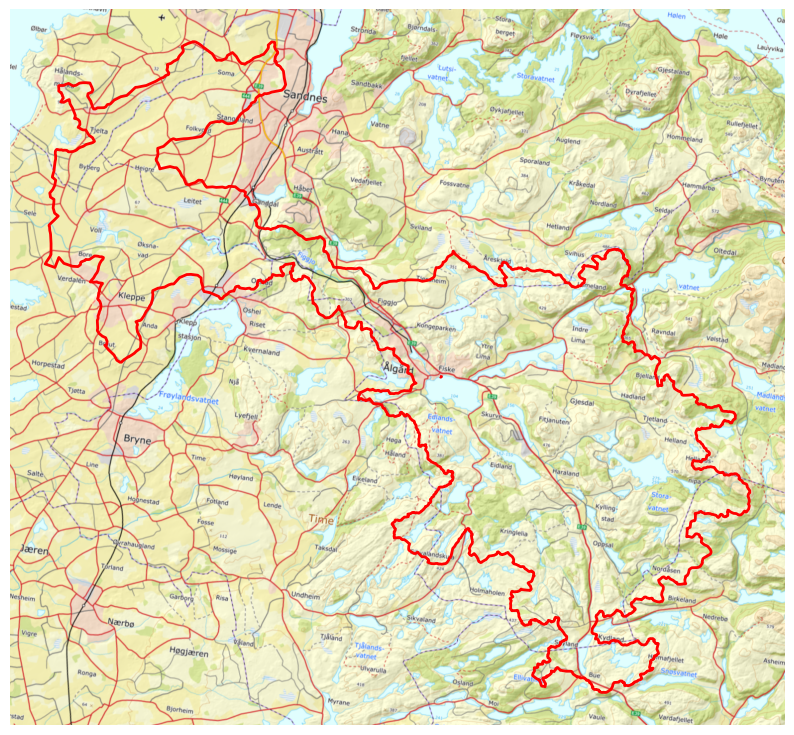

In [9]:
# Plot the specified regine and all contributing regines upstream
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

<Axes: >

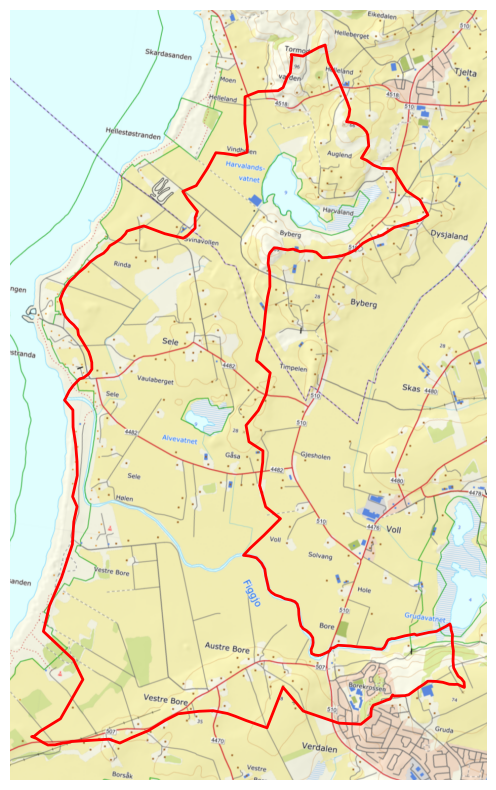

In [10]:
# Plot the specified regine and other regines on the downstream path
gdf, ax = teo.vis.plot_catchment(
    g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="down"
)
ax

Finally, because we included the keyword argument `add_offshore=True` when we assigned the regine hierarchy (see section 2, above), we can also aggregate data based on OSPAR maritime areas. For example, vassdragsområder `001` to `023` all drain to Skagerrak (see [here](https://github.com/NIVANorge/teotil3/blob/main/data/vassdragsomrader_ospar_regions.csv)), and including `add_offshore=True` means that `001_023` has been added to the adjacency matrix (by extending the basic regine dataset). The entire drainage area for Skagerrak can therefore be visualised efficiently, as shown below.

<Axes: >

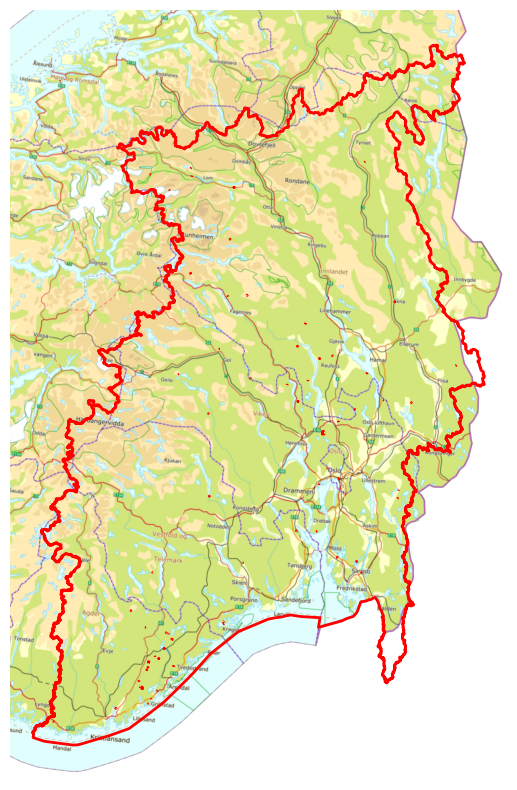

In [11]:
gdf, ax = teo.vis.plot_catchment(
    g, "001_023", reg_gdf, id_col="regine", include_connected=True, direct="up"
)
ax

## 4. Run the model

### 4.1. Regine-scale retention and transmission

The regine input datasets for TEOTIL3 are produced annually by NIVA and include regine-level retention and transmission factors for different chemical variables of interest. These factors are based on lake water residence times and the Vollenwieder principle - see [Section 3.2 of the forprosjekt report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=23) for a description of the approach and the development notebooks for [Tasks 2.4 and 2.5](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development#task-24-estimate-residence-times) for full details and code. 

Tutorial 03 will demonstrate how to run the model using the "real" input files. First, in this tutorial, we will explore the effects of regine-scale retention by running the model using the "real" retention factors, but with fixed "fake" input fluxes. This is a useful exercise, since it gives an indication of the importance of retention within the hydrological system.

### 4.2. Hypothetical examples using fixed input fluxes

The "standard" TEOTIL3 setup run annually by NIVA considers the following water quality parameters: DIN, TON, TDP, TPP, TOC and SS. The model also estimates TOTN (as DIN + TON) and TOTP (as TDP + TPP). In the "real" input files, each chemical parameter is also subdivided according to source (industry, aquaculture etc.), but in this example we will ignore this.

Using the regine scale transmission factors, we can accumulate inputs of each chemical variable over the catchment network. The input datasets include transmission factors for each parameter (i.e. columns named `trans_{par}`), which correspond to regine-level transmission estimated using the Vollenwieder principle (see the development notebook for [Task 2.5a](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-5a_est_vollenweider_params_from_data.ipynb) for details). In the code below, we first extract relevant columns from the regine dataset to create an input file for TEOTIL3 (see [Tutorial 01](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/tutorials/01_basic_concepts.ipynb) for an overview of the input format). We then create new columns for each parameter named `diff_{par}_kg` and set all values equal to 1000. This hypothetical dataset represents adding uniform diffuse inputs of one tonne of each parameter to *every regine in Norway*. This is not realistic, but it is a useful way of visualising the effects of in-lake retention on accumulated fluxes (see Tutorial 03 for an example using nutrient inputs based on real data).

In [12]:
# Read real input data
year = 2020
input_csv = f"/home/jovyan/shared/teotil3/annual_input_data/teotil3_input_data_{year}_nve2022_regine2022.csv"
input_df = pd.read_csv(input_csv)

# Build "fake" input dataset
par_list = ["din", "ton", "tdp", "tpp", "toc", "ss"]
cols = [
    "regine",
    "regine_down",
    "a_cat_land_km2",
    "runoff_mm/yr",
    "q_cat_m3/s",
] + [f"trans_{par}" for par in par_list]
input_df = input_df[cols]
for par in par_list:
    input_df[f"diff_{par}_kg"] = 1000  # Assign 1 tonne of 'par' to every catchment
input_df.head()

,regine,regine_down,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s,trans_din,trans_ton,trans_tdp,trans_tpp,trans_toc,trans_ss,diff_din_kg,diff_ton_kg,diff_tdp_kg,diff_tpp_kg,diff_toc_kg,diff_ss_kg
0,001.10,001.,1.160850,703.0,0.025849,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000,1000,1000,1000,1000,1000
1,001.1A1,001.,1.432412,724.0,0.032854,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000,1000,1000,1000,1000,1000
2,001.1A20,001.1A1,0.340114,694.0,0.007472,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000,1000,1000,1000,1000,1000
3,001.1A2A,001.1A20,17.647822,744.0,0.415909,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000,1000,1000,1000,1000,1000
4,001.1A2B,001.1A2A,41.298255,744.0,0.973276,0.175174,0.531847,0.321845,0.039669,0.215354,0.000013,1000,1000,1000,1000,1000,1000


In [13]:
%%time

# Run model
g = teo.model.run_model(
    input_df, id_col="regine", next_down_col="regine_down", totals_from_subfracs=True
)

CPU times: user 3.88 s, sys: 88.7 ms, total: 3.97 s
Wall time: 3.97 s


## 5. Explore results

### 5.1. Network diagrams

In addition to the "local" attributes of network nodes illustrated in Section 3, above, after running the model the nodes now have an additional set of `accum` attributes for parameters that can be accumulated downstream. "Accumulated" parameters can be visualised just the same as "local" ones: the images below show accumulated fluxes of TOTP up- and downstream of a specific node.

Accumulated attributes for catchment '028.A3':
{'diff_din_kg': 15500.255902940477,
 'diff_ss_kg': 6736.911854322059,
 'diff_tdp_kg': 14631.143429737172,
 'diff_toc_kg': 12913.84342164544,
 'diff_ton_kg': 19225.53793290424,
 'diff_totn_kg': 34725.79383584471,
 'diff_totp_kg': 24376.523327391886,
 'diff_tpp_kg': 9745.379897654713,
 'q_m3/s': 12.00924,
 'upstr_area_km2': 220.94870400000002}


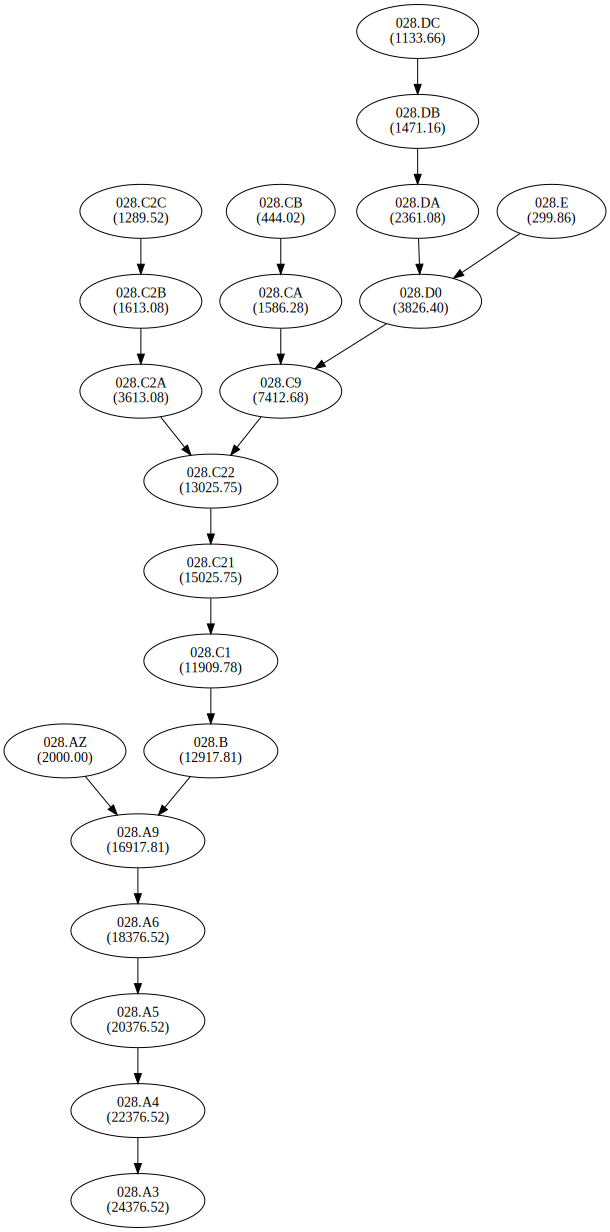

In [14]:
# Get 'accum' data for a specific catchment
print(f"Accumulated attributes for catchment '{reg_id}':")
pp.pprint(g.nodes[reg_id]["accum"])

# Plot accumulated TOTP upstream of node
teo.vis.plot_network(g, reg_id, direct="up", stat="accum", quant="diff_totp_kg")

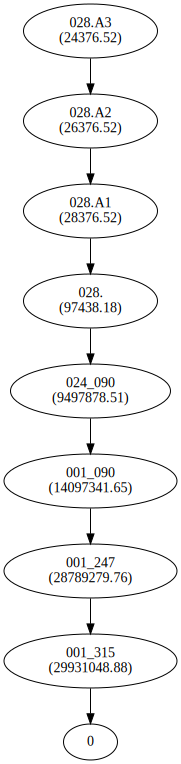

In [15]:
# Plot network downstream
teo.vis.plot_network(g, reg_id, direct="down", stat="accum", quant="diff_totp_kg")

Note that the downstream fluxes begin at the selected regine (`028.A3` in this example) and continue first to the outflow of vassdragsområde `028.`, and then to progressively larger aggregations of the vassdragsområder related to the OSPAR maritime areas. The final estimated flux from all mainland vassdragsområder (`001_315`) is around 30 kilotonnes (in this hypothetical example). There are around 24000 regines in the entire national dataset and we initially added 1 tonne of TDP and 1 tonne of TPP to each of them (i.e. ~48 kilotonnes of TOTP in total), so 18 kilotonnes (40%) of the phosphorus has been retained in the system.

### 5.2. Choropleth maps

TEOTIL3 provides convenient functions for creating choropleth maps based on the model output. As long as you have a geospatial dataset representing your catchments of interest (in this case `reg_gdf`, from above), you can colour the catchments according to any local or accumulated attribute (see the docstring of `teo.vis.choropleth_map` for full details).

<Axes: title={'center': 'Local Runoff (mm/yr)'}>

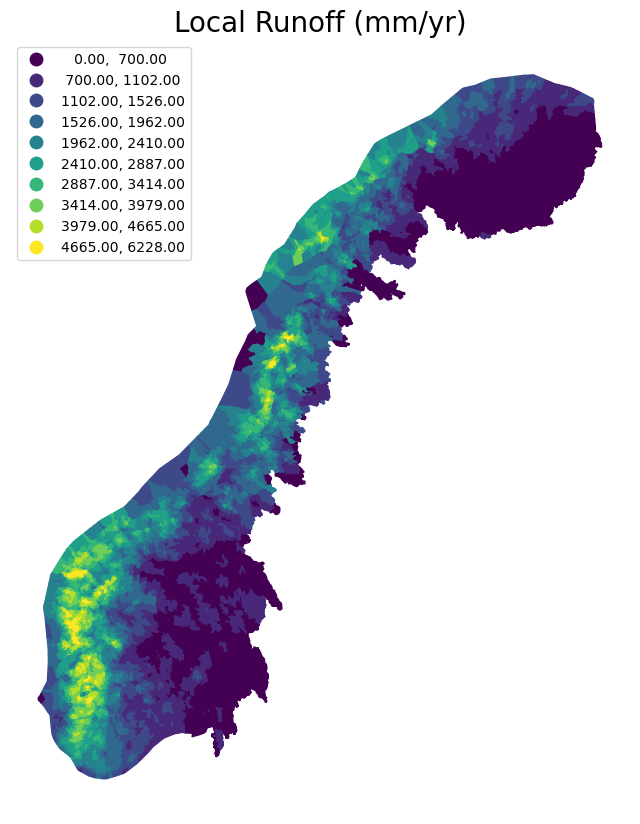

In [16]:
# Simple choropleth map of runoff
teo.vis.choropleth_map(
    g,
    reg_gdf,
    id_col="regine",
    stat="local",
    quant="runoff_mm/yr",
    trans="none",
    cmap="viridis",
    scheme="natural_breaks",
    n_classes=10,
    figsize=(8, 12),
    plot_path=None,
)

The same function can also be used to assign choropleth maps to previously created subplots using the `ax` keyword argument, as shown below.

In [ ]:
# Setup subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Params to plot, specificed as tuples
par_list = ['totn', "din", "ton", 'totp', "tdp", "tpp", "toc", "ss"]
plot_pars = [("accum", f"diff_{par}_kg") for par in par_list]
for idx, par in enumerate(plot_pars):
    teo.vis.choropleth_map(
        g,
        reg_gdf,
        id_col="regine",
        stat=par[0],
        quant=par[1],
        trans="none",
        cmap="viridis",
        scheme="natural_breaks",
        n_classes=5,
        plot_path=None,
        ax=axes[idx],
    )
plt.tight_layout()

### 5.3. Convert results to a dataframe

Finally, results from TEOTIL3 can easily be converted to a dataframe for further analysis (or e.g. to save as a CSV).

In [ ]:
# Convert to dataframe
res_df = teo.model.model_to_dataframe(g, id_col="regine", next_down_col="regine_down")
res_df.head()